# RNN

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
import os

import sklearn.preprocessing
import datetime

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Fundamental data

In [ ]:
data_url = 'https://bitbucket.org/hyuk125/lg_dic/raw/12b61c0c3c223378d52ae530da4dc220466e1006/dataset_day2/fundamentals.csv'
data = pd.read_csv(data_url, index_col=0)
data.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
print('\nnumber of different stocks: ', len(list(set(data.symbol))))
print(list(set(data.symbol))[:10])


number of different stocks:  501
['SJM', 'HBI', 'NKE', 'KHC', 'ROP', 'SNI', 'SWN', 'RAI', 'DHR', 'SRCL']


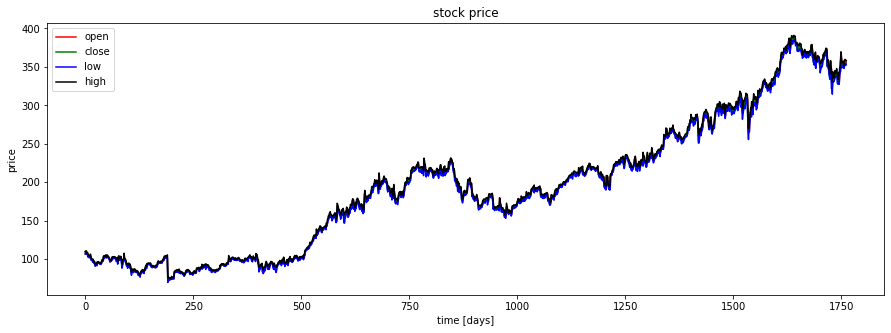

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(data[data.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(data[data.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(data[data.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(data[data.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()



### Preprocessing - minmax normalize

In [ ]:
def normalize_data(data):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    data['open'] = min_max_scaler.fit_transform(data.open.values.reshape(-1,1))
    data['high'] = min_max_scaler.fit_transform(data.high.values.reshape(-1,1))
    data['low'] = min_max_scaler.fit_transform(data.low.values.reshape(-1,1))
    data['close'] = min_max_scaler.fit_transform(data.close.values.reshape(-1,1))
    return data

In [ ]:
data_norm = normalize_data(data[data.symbol=='EQIX'].copy())
data_norm.drop(['symbol'],1,inplace=True)
data_norm.drop(['volume'],1,inplace=True)

In [ ]:
data_norm

,open,close,low,high
date,,,,
2010-01-04,0.109250,0.122904,0.117440,0.110911
2010-01-05,0.118896,0.119708,0.123361,0.110816
2010-01-06,0.116886,0.122810,0.122855,0.113912
2010-01-07,0.117828,0.115791,0.117852,0.113217
2010-01-08,0.110130,0.114161,0.115509,0.103519
...,...,...,...,...
2016-12-23,0.880884,0.897089,0.889589,0.895976
2016-12-27,0.895588,0.897433,0.904598,0.900745
2016-12-28,0.896971,0.888471,0.899278,0.900430


### Train Test split

Making sliding window data

In [ ]:
data_norm_raw = data_norm.values.astype(float)

In [ ]:
data_norm_raw

array([[0.10925029, 0.12290433, 0.11744033, 0.11091105],
       [0.11889648, 0.11970795, 0.12336141, 0.11081625],
       [0.11688555, 0.12281032, 0.1228548 , 0.11391205],
       ...,
       [0.896971  , 0.88847098, 0.89927808, 0.90042956],
       [0.88503112, 0.89859292, 0.89440195, 0.89847102],
       [0.89989312, 0.89959573, 0.89943645, 0.89660725]])

In [ ]:
sliding_data = []
window_size = 20
for index in range(len(data_norm_raw) - window_size):
    sliding_data.append(data_norm_raw[index : index + window_size])

sliding_data = torch.FloatTensor(sliding_data)

In [ ]:
sliding_data.shape

torch.Size([1742, 20, 4])

Split train/test, make batch data

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(sliding_data, test_size=0.2, shuffle=False)

In [ ]:
batch_size=50

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)

## Define Model 

In [ ]:
import torch.nn as nn

In [ ]:
rnn_hidden = 20
rnn_layers = 2
intput_features = train.size(2)
output_features = test.size(2)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.rnn = nn.RNN(input_size=intput_features, hidden_size=rnn_hidden, num_layers=rnn_layers, batch_first=True)
        self.fc = nn.Linear(rnn_hidden, output_features)

    def forward(self, x):
        h0 = torch.zeros(rnn_layers, x.size(0), rnn_hidden).to(device)

        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) # many to one solution

        return out


net = Net()
net.to(device)

Net(
  (rnn): RNN(4, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=4, bias=True)
)

## Learning the model

In [ ]:
learning_rate = 0.001
epochs = 1000

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(epochs):
    running_cost = 0.0

    for step, (batch_data) in enumerate(trainloader):
        batch_x = batch_data[:, :-1, :].float().to(device)
        batch_y = batch_data[:, -1, :].to(device)

        outputs = net(batch_x)
        cost = criterion(outputs, batch_y)

        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        running_cost += cost.item()
        if step % 10 == 0:
            print('[%d, %5d] cost: %.3f' % (epoch + 1, step + 1, running_cost))
            running_cost = 0.0
            

## Trace

In [ ]:
X_test = test[:, :-1, :].float().to(device)
y_test = test[:, -1, :].view(-1, 1, output_features).to(device)

In [ ]:
X_test.shape, y_test.shape

(torch.Size([349, 19, 4]), torch.Size([349, 1, 4]))

In [ ]:
y_predict = net(X_test).cpu()

In [ ]:
y_predict.shape

torch.Size([349, 4])

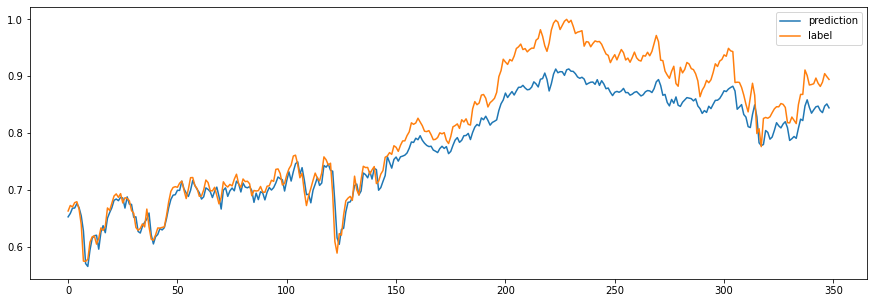

In [ ]:
value = 2 # 0 = open, 1 = close, 2 = highest, 3 = lowest
with torch.no_grad():
    plt.figure(figsize=[15, 5])
    plt.plot(y_predict[:,value], label='prediction')
    plt.plot(y_test[:, 0, value].cpu(), label='label')
    plt.legend()